In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from import_clean_process import cleaning_your_bike
import sqlite3
%load_ext sql

In [2]:
colors = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']

keys = ["red", "salmon","tan",'light_green','aqua_green','purple']
values = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']
color_dct = dict(zip(keys, values))

In [2]:
%sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db

In [3]:
def sql_df_creation(year):
    
    # define the sql table name
    yr =' yr_' + str(year)
    
    # run sql query and store as dataframe
    sql_result = %sql SELECT starttime, bikeid FROM $yr;
    df_sql = sql_result.DataFrame()
    
    # do datetime conversions
    df_sql['starttime'] = pd.to_datetime(df_sql['starttime'])
    df_sql['year'] = df_sql['starttime'].dt.year
    df_sql['month'] = df_sql['starttime'].dt.month
    df_sql.loc[df_sql['month'] == 1, ['month']] = 'January'
    df_sql.loc[df_sql['month'] == 2, ['month']] = 'February'
    df_sql.loc[df_sql['month'] == 3, ['month']] = 'March'
    df_sql.loc[df_sql['month'] == 4, ['month']] = 'April'
    df_sql.loc[df_sql['month'] == 5, ['month']] = 'May'
    df_sql.loc[df_sql['month'] == 6, ['month']] = 'June'
    df_sql.loc[df_sql['month'] == 7, ['month']] = 'July'
    df_sql.loc[df_sql['month'] == 8, ['month']] = 'August'
    df_sql.loc[df_sql['month'] == 9, ['month']] = 'September'
    df_sql.loc[df_sql['month'] == 10, ['month']] = 'October'
    df_sql.loc[df_sql['month'] == 11, ['month']] = 'November'
    df_sql.loc[df_sql['month'] == 12, ['month']] = 'December'
    df_sql.drop(columns=['starttime'], inplace=True)
    
    return df_sql

In [4]:
def unique_bikes_sql():
    
    %sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
    
    # define years
    years = list(np.arange(2013,2020+1))
    
    # define months
    months = ['January','February','March',"April","May","June","July","August","September","October","November", "December"]
    
    # initialize empty dataframe to store number of unique bikes for each month and year
    result = pd.DataFrame({'bikes': pd.Series([], dtype='int'),'year': pd.Series([], dtype='int'),'month': pd.Series([], dtype='str')})
    
    # initialize empty list to store number of unique bikes for each month
    unique_bikes = []
    
    for year in years:
        
        print('before_query\n')
        
        df = sql_df_creation(year)
        
        print(year)
        
        # create for loop to count number of unique bikes after filtering to a given month
        for month in months:
            # filter down to given month
            x = df.loc[(df['year'] == year) & (df['month'] == month)]
            # append unique number to list created above
            unique_bikes.append(len(x.bikeid.unique()))

        # create dataframe with results
        bike = pd.DataFrame(unique_bikes, columns = ['bikes'])
        
        # add columns denoting year and month
        bike['year'] = int(year)
        bike['month'] = months
        
        # concatenate the above result with prior results
        result = pd.concat([result, bike])
        
        # clear bike number list and delete bike dataframe in preparation for next loop in year
        unique_bikes.clear()
        del bike
        del df
        
    
    return result

In [5]:
df_bike_full = unique_bikes_sql()
df_bike_full.sample(15)

before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2013
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2014
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2015
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2016
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2017
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2018
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
2019
before_query

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/cit

,bikes,year,month
10,7971,2015,November
5,5897,2015,June
0,0,2013,January
4,5476,2015,May
11,0,2020,December
8,10267,2016,September
1,4466,2015,February
6,8413,2016,July
4,6186,2014,May
6,5461,2013,July


### Convert columns to datetime to prep for graphing

In [22]:
df_bike_full['datetime'] = pd.to_datetime(df_bike_full['year'].astype(str)  + df_bike_full['month'], format='%Y%B')
df_bike_full.set_index('datetime', inplace=True)
df_bike_full.drop(columns=['year', 'month'], inplace=True)
df_bike_full = df_bike_full.loc[(df_bike_full!=0).any(axis=1)]
df_bike_full.sample(15)

KeyError: 'year'

### Look back n years for maximum number of bikes to calculate % of bike fleet

In [5]:
def max_past_value_in_N_months(df, N_months=12):
    
    # initiate empty list to track the max values
    max_prev_N_months = []
    
    # create for loop to look back at max value in the last N months 
    for i in np.arange(1,df.shape[0]+1):
        # if we are below N months then select all dataframe rows up until 'i'
        if i <=N_months:
            max_prev_N_months.append(df[0:i]['bikes'].max())
        #if we are above N_months then start taking subset of rows from 'i - N_months' to 'i'
        else:
            max_prev_N_months.append(df[i-N_months:i]['bikes'].max())
    
    return max_prev_N_months

In [6]:
max_unique_bikes_in_24_months = max_past_value_in_N_months(df_bike_full, N_months=24)
df_bike_full['max_past_24m'] = max_unique_bikes_in_24_months
df_bike_full.head(15)

,Unnamed: 0,bikes,max_past_24m
datetime,,,
2013-02-01,1,0,0
2013-03-01,2,0,0
2013-04-01,3,0,0
2013-05-01,4,0,0
2013-06-01,5,5794,5794
2013-07-01,6,5461,5794
2013-08-01,7,5750,5794
2013-09-01,8,5444,5794
2013-10-01,9,5722,5794


In [7]:
df_bike_full['% Fleet on Road'] = round(100 * (df_bike_full['bikes'] / df_bike_full['max_past_24m']), 1).fillna(0)
df_bike_full.head(5)

,Unnamed: 0,bikes,max_past_24m,% Fleet on Road
datetime,,,,
2013-02-01,1,0,0,0.0
2013-03-01,2,0,0,0.0
2013-04-01,3,0,0,0.0
2013-05-01,4,0,0,0.0
2013-06-01,5,5794,5794,100.0


In [37]:
# df_bike_full.to_csv('unique_bikes_per_month.csv')

In [59]:
df_bike_full = pd.read_csv('unique_bikes_per_month.csv')

In [60]:
df_bike_full.index

RangeIndex(start=0, stop=84, step=1)

In [61]:
df_bike_full = df_bike_full.loc[df_bike_full['bikes']!=0]
df_bike_full['datetime'] = pd.to_datetime(df_bike_full['datetime'])
df_bike_full.drop(columns=['Unnamed: 0','bikes','max_past_24m'], inplace = True)
df_bike_full.set_index('datetime', inplace=True)

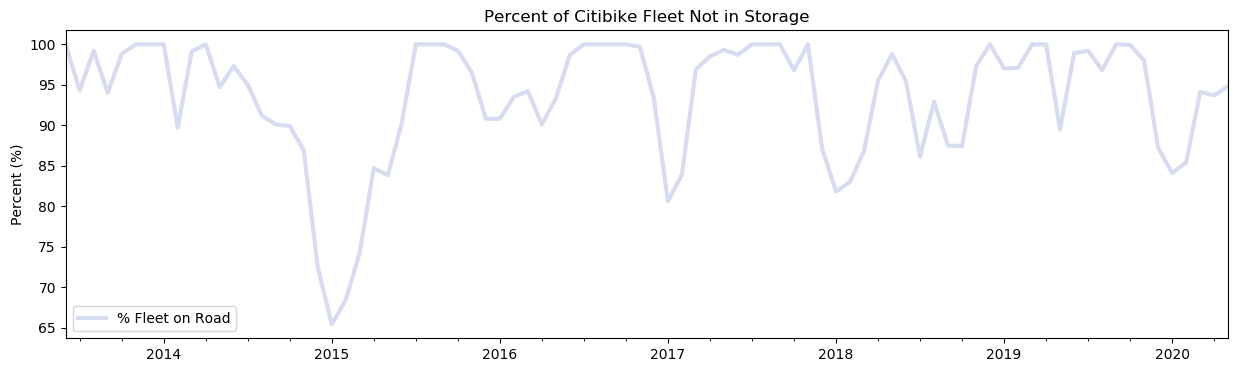

In [63]:
df_bike_full[['% Fleet on Road']].plot(figsize=(15,4), color=color_dct['purple'], linewidth=3, alpha=0.7)
plt.xlabel('')
plt.ylabel('Percent (%)')
plt.title('Percent of Citibike Fleet Not in Storage')
plt.show()

### Import NOAA weather data for central park

In [64]:
df_temp = pd.read_csv('./_weather/NOAA_Temp_NYC_Processed.csv')
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y-%m-%d %H:%M:%S.%f')
df_temp.set_index('date', inplace=True)
df_temp = df_temp[["Temperature"]].resample('M', label='left', loffset="1d").median()#.resample("1m").median()
df_temp.head(10)

,Temperature
date,
2013-01-01,38.0
2013-02-01,34.0
2013-03-01,38.0
2013-04-01,53.0
2013-05-01,60.0
2013-06-01,70.0
2013-07-01,77.0
2013-08-01,73.0
2013-09-01,68.0


### Combine datasets and plot

In [65]:
result = pd.concat([df_bike_full, df_temp], axis=1, sort=False)[5:]
result

,% Fleet on Road,Temperature
2013-06-01,100.0,70.0
2013-07-01,94.3,77.0
2013-08-01,99.2,73.0
2013-09-01,94.0,68.0
2013-10-01,98.8,61.0
...,...,...
2020-02-01,85.4,41.0
2020-03-01,94.1,45.0
2020-04-01,93.7,50.0
2020-05-01,94.8,60.0


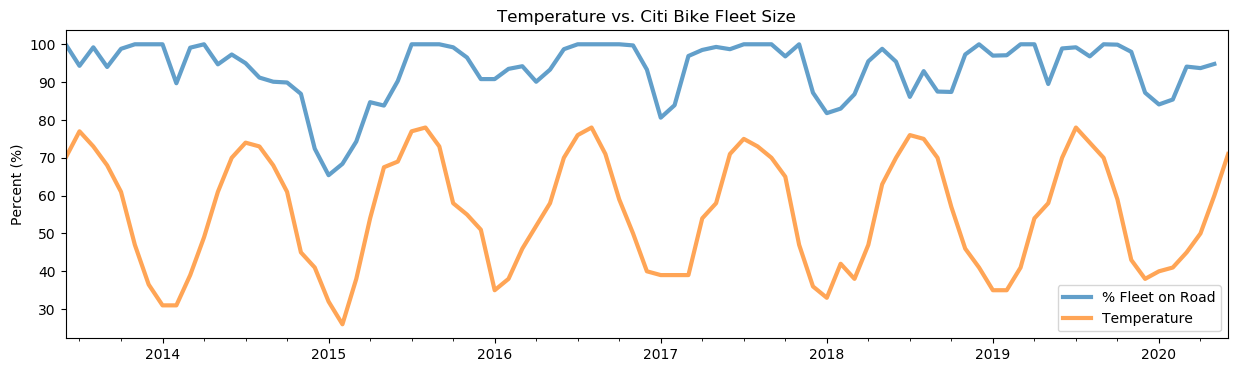

In [66]:
result[['% Fleet on Road', "Temperature"]].plot(figsize=(15,4), linewidth=3, alpha=0.7) #, colors=color_dct['red']
# df_bikes[['% Fleet on Road']].plot(figsize=(15,4), color=color_dct['purple'], linewidth=3, alpha=0.7)
plt.xlabel('')
plt.ylabel('Percent (%)')
plt.title('Temperature vs. Citi Bike Fleet Size')
plt.show()

In [67]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

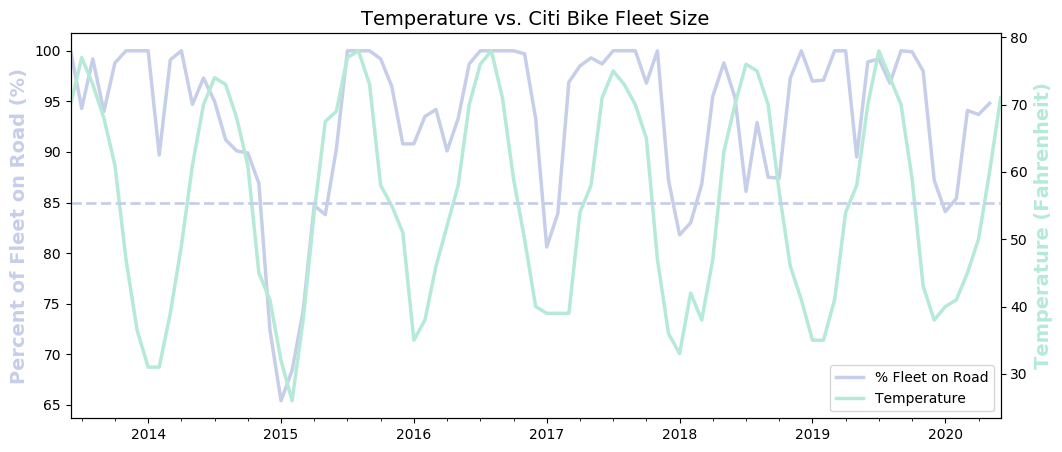

In [83]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.title('Temperature vs. Citi Bike Fleet Size', fontsize=14)

ax1 = result['% Fleet on Road'].plot(color=color_dct['purple'], label='% Fleet on Road', linewidth=2.5)
ax2 = result["Temperature"].plot(color=color_dct['aqua_green'], secondary_y=True, label="Temperature", linewidth=2.5)

ax1.set_ylabel('Percent of Fleet on Road (%)', color=color_dct['purple'], fontsize=14, weight='bold')
ax2.set_ylabel('Temperature (Fahrenheit)', color=color_dct['aqua_green'], fontsize=14, weight='bold')

# ax1.tick_params(axis='y', colors=color_dct['purple'], labelsize=14)#, weight='bold')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

linestyles = ['-', '--', '-.', ':']
plt.axhline(y=55.4, linewidth=2, color=color_dct['purple'], ls=linestyles[1])

plt.legend(h1+h2, l1+l2, loc=4)
plt.show()

In [ ]:
test.sort_values(by=['bikes'], ascending=False)

In [ ]:
colors = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']

keys = ["red", "salmon","tan",'light_green','aqua_green','purple']
values = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']

color_dct = dict(zip(keys, values))

### Import and clean all data

In [ ]:
path = '/Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/rand_5/scwinning_5.csv'
df_all = cleaning_your_bike(path)

### Define function that goes through every month of every year and counts unique number of bikes

In [ ]:
def unique_bikes(df):
    
    # define years
    years = list(np.arange(2013,2020+1))
    
    # define months
    months = ['January','February','March',"April","May","June","July","August","September","October","November", "December"]
    
    # initialize empty dataframe to store number of unique bikes for each month and year
    result = pd.DataFrame({'bikes': pd.Series([], dtype='int'),'year': pd.Series([], dtype='int'),'month': pd.Series([], dtype='str')})
    
    # initialize empty list to store number of unique bikes for each month
    unique_bikes = []
    
    for year in years:
        
        print(year)
        
        # create for loop to count number of unique bikes after filtering to a given month
        for month in months:
            # filter down to given month
            x = df.loc[(df['year'] == year) & (df['month'] == month)]
            # append unique number to list created above
            unique_bikes.append(len(x.bikeid.unique()))

        # create dataframe with results
        bike = pd.DataFrame(unique_bikes, columns = ['bikes'])
        
        # add columns denoting year and month
        bike['year'] = int(year)
        bike['month'] = months
        
        # concatenate the above result with prior results
        result = pd.concat([result, bike])
        
        # clear bike number list and delete bike dataframe in preparation for next loop in year
        unique_bikes.clear()
        del bike
        
    
    return result

### Process whole DF to get number of bikes per month and year

In [ ]:
df_all.head(2)

In [ ]:
df_bikes = unique_bikes(df_all)
# df_bikes.sample(10)

### Convert columns to datetime to prep for graphing

In [ ]:
test_post = test.copy()
test_post['datetime'] = pd.to_datetime(test_post['year'].astype(str)  + test_post['month'], format='%Y%B')
test_post.set_index('datetime', inplace=True)
test_post.drop(columns=['year', 'month'], inplace=True)
test_post = test_post.loc[(test_post!=0).any(axis=1)]
test_post

In [ ]:
df_bikes['datetime'] = pd.to_datetime(df_bikes['year'].astype(str)  + df_bikes['month'], format='%Y%B')
df_bikes.set_index('datetime', inplace=True)
df_bikes.drop(columns=['year', 'month'], inplace=True)
df_bikes = df_bikes.loc[(df_bikes!=0).any(axis=1)]
df_bikes

### Look back n years for maximum number of bikes to calculate % of bike fleet

In [ ]:
def max_past_value_in_N_months(df, N_months=12):
    
    # initiate empty list to track the max values
    max_prev_N_months = []
    
    # create for loop to look back at max value in the last N months 
    for i in np.arange(1,df.shape[0]+1):
        # if we are below N months then select all dataframe rows up until 'i'
        if i <=N_months:
            max_prev_N_months.append(df[0:i]['bikes'].max())
        #if we are above N_months then start taking subset of rows from 'i - N_months' to 'i'
        else:
            max_prev_N_months.append(df[i-N_months:i]['bikes'].max())
    
    return max_prev_N_months

In [ ]:
test_post
max_unique_bikes_in_24_months = max_past_value_in_N_months(test_post, N_months=24)
test_post['max_past_24m'] = max_unique_bikes_in_24_months
test_post.head(10)

In [ ]:
max_unique_bikes_in_24_months = max_past_value_in_N_months(df_bikes, N_months=24)
df_bikes['max_past_24m'] = max_unique_bikes_in_24_months
df_bikes.head(10)

### Calculate percent of fleet in the dataframe and plot

In [ ]:
test_post
test_post['% Fleet on Road'] = round(100 * (test_post['bikes'] / test_post['max_past_24m']), 1).fillna(0)
test_post.head(5)

In [ ]:
df_bikes['% Fleet on Road'] = round(100 * (df_bikes['bikes'] / df_bikes['max_past_24m']), 1).fillna(0)
df_bikes.head(5)

In [ ]:
test_post[['% Fleet on Road']].plot(figsize=(15,4), color=color_dct['purple'], linewidth=3, alpha=0.7)
plt.xlabel('')
plt.ylabel('Median Monthly Temperature (F)')
plt.title('Monthly Temperature in Central Park')
plt.show()

In [ ]:
df_bikes[['% Fleet on Road']].plot(figsize=(15,4), color=color_dct['purple'], linewidth=3, alpha=0.7)
plt.xlabel('')
plt.ylabel('Median Monthly Temperature (F)')
plt.title('Monthly Temperature in Central Park')
plt.show()

### Import NOAA weather data for central park

In [ ]:
df_temp = pd.read_csv('./_weather/NOAA_Temp_NYC_Processed.csv')
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y-%m-%d %H:%M:%S.%f')
df_temp.set_index('date', inplace=True)
df_temp.head(2)

In [ ]:
df_temp = df_temp[["Temperature"]].resample("1m").median()

In [ ]:
result = pd.concat([df_bikes, df_temp], axis=1, sort=False)
result

In [ ]:
result[['% Fleet on Road', "Temperature"]].resample("1m").median().plot(figsize=(15,4), linewidth=3, alpha=0.7) #, colors=color_dct['red']
# df_bikes[['% Fleet on Road']].plot(figsize=(15,4), color=color_dct['purple'], linewidth=3, alpha=0.7)
plt.xlabel('')
plt.ylabel('Median Monthly Temperature (F)')
plt.title('Monthly Temperature in Central Park')
plt.show()

### Testing to see memory usage of a year dataframe and the full dataframe
- 2013 is 140 MB
- 2019 is 540 MB
- Full sampled 5% is 2.4 GB

In [ ]:
%%time
df_2013 = pd.read_csv('/Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/rand_5/yr_2013.csv',\
              dtype={"tripduration":float,\
              "starttime":object,\
              "stoptime":object,\
              "start_station_id":float,\
              "start_station_name":object,\
              "start_station_latitude":float,\
              "start_station_longitude":float,\
              "end_station_id":float,\
              "end_station_name":object,\
              "end_station_latitude":float,\
              "end_station_longitude":float,\
              "bikeid":int,\
              "usertype":object,\
              "birth_year":object,\
              "gender":int,\
              "counter":int,\
              "year":int,\
              "age":int})

In [ ]:
df_2013.info(memory_usage="deep")

In [ ]:
del df_2013

In [ ]:
%%time
df_all = pd.read_csv('/Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/rand_5/scwinning_5.csv',\
              dtype={"tripduration":float,\
              "starttime":object,\
              "stoptime":object,\
              "start_station_id":float,\
              "start_station_name":object,\
              "start_station_latitude":float,\
              "start_station_longitude":float,\
              "end_station_id":float,\
              "end_station_name":object,\
              "end_station_latitude":float,\
              "end_station_longitude":float,\
              "bikeid":int,\
              "usertype":object,\
              "birth_year":object,\
              "gender":int,\
              "counter":int,\
              "year":int,\
              "age":int})

In [ ]:
df_all.info(memory_usage="deep")

In [ ]:
del df_all